<a href="https://colab.research.google.com/github/danielyangdev/CAIS-F23-Curriculum/blob/main/%5BL1%5D_Intro_to_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lesson 1 Notebook: Neural Networks**
**Notebook Objective:**
In this notebook, you'll experiment with defining your own neural network architecture to classify handwritten digits of the MNIST dataset. You'll work with loading and viewing the data, as well as initializing and training a neural network from scratch. Let's get started!
**Useful Links:**
- [A Comprehensive Guide to Data Loading](https://blog.paperspace.com/dataloaders-abstractions-pytorch/): covers built-in datasets within Pytorch and the *DataLoader* class
* [Pytorch Neural Network(NN Module)](https://pytorch.org/docs/stable/nn.html)
* [Torch Optimizers](https://pytorch.org/docs/stable/optim.html)
* [Activation Functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)
* [Cost/Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

## **Loading the Data**

We'll be using the pre-labeled [**MNIST dataset**](https://en.wikipedia.org/wiki/MNIST_database), which contains 70,000 grayscale images of handwritten digits, along with their corresponding digit labels.
We will use 60,000 images for training, and the remaining 10,000 for evaluation. We can easily access this dataset using `torchvision.datasets.MNIST()`, and define our train and test loaders using `torch.utils.data.DataLoader`. Hint: we want to shuffle the training data in order to maximize similarity of different batches.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import random

# Device config: use cuda if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define batch size for data loader: number of samples processed before the model is updated
batch_size = 32 #TODO--------- up to you but conventionally power of 2   # Number of samples processed before the model is updated

# Load and Initalize MNIST training and test data from PyTorch
  #Variable Defs:
    #root= string: directory where the database is stored.
    #train= boolean: defines if training set
    #download= boolean: if want to download dataset
    #transform= function: to specify what transformation is taking place

# Load MNIST training and test data from PyTorch
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# Create data loader
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True) #TODO: use torch.utils.data.DataLoader and define the dataset, batch_size, and shuffle parameters
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = True) #TODO: use torch.utils.data.DataLoader and define the dataset, batch_size, and shuffle parameters

100%|██████████| 9912422/9912422 [00:00<00:00, 19616514.32it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 63655120.24it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29432456.20it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13111169.15it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [2]:
# Data Exploration

# How many training and testing examples
#TODO-------check the length of the MNIST test set using the Python len function to
#       get the number of items to make sure it matches what we expect.
print("Number of training examples:", len(train_data))
print("Number of testing examples:", len(test_data))

# What features are given for each example?
examples = iter(train_loader)
samples, labels = next(examples)
print("Sample shape: ", samples.shape)
print("Label shape: ", labels.shape)

# What do our labels look like?
print("Labels: ", labels)

Number of training examples: 60000
Number of testing examples: 10000
Sample shape:  torch.Size([32, 1, 28, 28])
Label shape:  torch.Size([32])
Labels:  tensor([0, 6, 0, 4, 6, 2, 5, 2, 8, 4, 5, 9, 2, 9, 9, 2, 5, 4, 2, 1, 1, 5, 7, 5,
        2, 9, 3, 8, 6, 8, 9, 7])


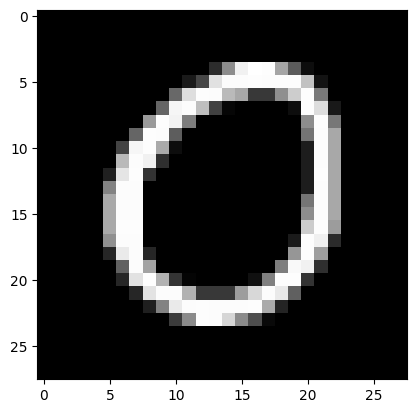

In [5]:
# Data Visualization: use matplotlib to see some given images of handwritten digits
import matplotlib.pyplot as plt

# Change this number and re-run the cell to see different image samples!
sample_num = random.randint(0, len(samples) - 1)

plt.imshow(samples[sample_num][0], cmap="gray")
plt.show()

## **Defining the Neural Network**

1. **Initialize the network**: We'll first define our own NN Model with specific layers and activation functions that will be used during training. We will decide the "settings" of our NN, also known as the **hyperparameters**, such as the number of layers, number of neurons per layer, etc. We will use `nn.Linear(input_size, output_size)` for each of our layers, and **ReLU** as our intermediate activation functions.
- [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [torch.nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
2. **Define forward method**: Given that we're using PyTorch, we need to define our own method for forwarding input data through the network. All you need to do is to pass through the input through each layer and activation function that you've defined in step 1! :)
2. **Compile** the network to get ready for training. This tells the network what cost/loss function to use ("cost" and "loss" are used interchangeably), and what type of gradient descent, or optimizer, to use. Since we are outputting 10 different classes of digits, we want to use **categorical crossentropy loss**.
- [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
- [torch.optim](https://pytorch.org/docs/stable/optim.html)
3. **Training** the network, using the set of training images. This actually feeds the training data into the network, and uses gradient descent and backpropagation to adjust the network's weights in order to minimize the cost function.

In [8]:
# TODO: Define function to create our own neural network

# Parameters
input_size = 28*28 #TODO    # Hint: image size is 28x28, and we want to flatten the image into a ?? by 1 vector
num_classes = 10 #TODO   # Hint: our inputs include 0-9
num_epochs = 5 #TODO    # Number of times we loop through the entire training dataset

class NN(nn.Module):
  ############ YOUR CODE STARTS HERE ############
  # 1. Initialize our own NN model
  def __init__(self, input_size, num_classes):
    h1 = 64
    h2 = 32

    super(NN, self).__init__()
    # Use ReLU activation function
    self.relu = nn.ReLU() #TODO-----------
    # Input layer
    self.input_layer = nn.Linear(input_size, h1) #TODO------------
    # Hidden layers: use at least 1 hidden layer!
    self.hidden1 = nn.Linear(h1, h2) #TODO-----------
    # Output layer
    self.output_layer = nn.Linear(h2, num_classes) #TODO------------

  # 2. Define method for forwarding input data
  def forward(self, sample):

    out = self.input_layer(sample) #TODO: pass input into input layer
    out = self.relu(out) #TODO: activation function

    out = self.hidden(out) #TODO: pass into all hidden layer(s)
    out = self.relu(out) #TODO: activation function

    out = self.output_layer(out) #TODO: forward to output layer
    return out
  ############ YOUR CODE ENDS HERE ################
# Initialize our model by passing in our hyperparameters defined previously
nn_model = NN(input_size, num_classes)
print("My NN Model: ", nn_model)

My NN Model:  NN(
  (relu): ReLU()
  (input_layer): Linear(in_features=784, out_features=64, bias=True)
  (hidden1): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=10, bias=True)
)


In [10]:
# 3 Network Compilation: Loss function & Optimizer

loss_function = nn.L1Loss() #TODO: categorical cross entropy loss
optimizer = torch.optim.Adam #TODO: define an optimizer to use with torch.optim

In [12]:
# 4 -- Network Training

# TODO Fit the model to the data. Number of epochs: 50 (up to you). Batch size: 32 (up to you, conventionally a power of 2)
# ** Values for Epoch and Batch are defined in previous cells
total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # Reshape our images from 2D(28x28) to 1D(784)
    images = images.to(device) # TODO ____________.to(device)
    labels = labels.to(device)

    # Call functions we've previously defined to perform forward pass & calculate loss
    output = optimizer() #TODO-----------
    loss = loss_function() #TODO-----------

    # Backward pass
    optimizer.optimizer # TODO: Empty accumulated values in the gradient attribute
    loss.loss_function # TODO: Backpropagation
    optimizer.optimizer  # TODO: Update parameters

    # Print out training process
    if (i+1) % 100 == 0:
      print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{total_steps}, loss = {loss.item():.4f}')

SyntaxError: ignored

## **Evaluating the Model**
Here we will see how our model performs on unseen test data.

In [17]:
# 4 -- Evaluate on the test data!

# Reduce memory consumption by not letting PyTorch to calculate gradient since no backword passing is involved in testing
with torch.no_grad():
  accuracy_arr = []
  loss_arr = []
  correct_predict_num = 0
  sample_num = 0  # Total num of test samples in current loop
  # Loop all batches in the test dataset
  for images, labels in test_loader:
    # Reshape inputs
    images = images.reshape(25088).to(device) #Calculate dimensions to reshape
    labels = labels.to(device)
    # Use our own model to make prediction
    output = nn_model(images)

    # Get Prediction and loss
    _, predictions = torch.max(output, 1)
    sample_num += labels.shape[0]
    correct_predict_num += (predictions == labels).sum().item()

    # Print out loss and accuracy
    loss = loss_function(output, labels)
    accuracy = torch.evaluate() #TODO: calculate accuracy
    accuracy_arr.append(accuracy)
    loss_arr.append(loss)

print(f'Average Accuracy: {sum(accuracy_arr)/len(accuracy_arr)}')
print(f'Average Cost/Loss: {sum(loss_arr)/len(loss_arr)}')


RuntimeError: ignored

**Final Sanity Check:** Make sure the our neural network's predictions match up with the actual images

Prediction output:  tensor([ -0.6016,  -5.6135,  16.3111,   7.2328, -11.2424,  -6.7340,  -6.2604,
          5.3097,   2.2134,  -5.3936], grad_fn=<AddBackward0>)
Predicted digit:  2


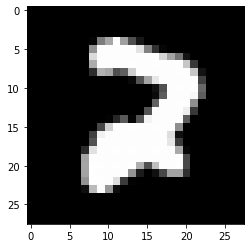

In [ ]:
# Pick a random test sample and see what the model predicts!
sample_num = 5

images, labels = iter(train_loader).next()
test_images = images.reshape(-1, 28*28).to(device)
test_labels = labels.to(device)

prediction_outputs = nn_model(test_images[sample_num])  # outputted probabilities vector
print("Prediction output: ", prediction_outputs)

predicted_digit = torch.argmax(prediction_outputs) # pick the class with highest probability --> final prediction
print("Predicted digit: ", predicted_digit.item()) # print predicted classification

# Show actual input image
plt.imshow(images[sample_num][0], cmap="gray")
plt.show()

# Congrats! You just completed your first deep learning model!

## Some questions to think about:
### 1. How to initialize weights and biases for NN for an efficient training process?
  1. Too large / small initializations may lead to exploding / vanishing gradient problem
  2. Rules of thumb:
    1. The mean of the activations should be zero.
    2. The variance of the activations should stay the same across every layer.
  3. See the [article](https://www.deeplearning.ai/ai-notes/initialization) for more detailed justification for Xavier Initialization

### 2. How many layers should we have for hidden layers?
- If your data is linearly separable, then no need to have hidden layers.
- In most cases, it is not. Since MNIST is a small and simple image, usually having 2 hidden layers is sufficient.
- Reference table:

Num of layers | Result
	:--------:|:-------:
0 | Only capable of representing linear separable functions or decisions
1 | Can approximate any function that contains a continuous mapping
from one finite space to another.
2 | Can represent an arbitrary decision boundary to arbitrary accuracy with rational activation functions and can approximate any smooth mapping to any accuracy.
> 2 | Additional layers can learn complex representations (sort of automatic feature engineering) for layer layers.

## 3. How to decide number of neurons?
1. Too *few* neurons: Unable to adequately detect signals in a complicated data set, causing underfitting
2. Too *many* neurons:
  1. May cause overfitting: reflect information from training dataset very well but have poor capability of making predictions on unseen data
  2. Also increases runtime & makes the neural network more difficult to train
3. General rule of thumb:
  1. The number of hidden neurons should be between the size of the input layer and the size of the output layer.
  2. The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
  3. The number of hidden neurons should be less than twice the size of the input layer.
3. Even more optimal: [apply optimization](https://towardsdatascience.com/pruning-neural-networks-1bb3ab5791f9) such as a pruning algorithm to remove redundant neurons / prune weights
  1. Removing a weight that is setting output of a neuron to 0
  2. Use activation values as criteria: remove neurons that always output 0 (i.e. have little impact on the network)
  3. Based on parameters of a neuron: if 2 neurons have very similar weights & biases, remove 1 while preserve functionality

## 4. How to choose an activation function?
1. Sigmoid: 0 < output < 1
  - Used if need to output probabilities
  - Can cause the vanishing gradient problem
2. Tanh: -1 <= output <= 1
  - Allow positive & negative outputs → more efficient weight updating
  - Alleviate vanishing gradient to some extent but still cannot completely overcome it
3. Relu:
  - Most popular one used for hidden layers, as it overcomes vanishing gradients for backprop.
  - However, some gradients can die if activation < 0 → Leaky ReLU
4. Softmax:
  - Calculate probabilities distribution of 1 event over n different events
  - Used if our NN model is handling multiple classes problem, and it’s used in the last output layer






## Additional Resources:
* CAIS++ [Blog](http://caisplusplus.usc.edu/blog/curriculum/lesson4) Posts
* [3Blue1Brown](https://www.youtube.com/watch?v=aircAruvnKk) Videos
* ML Cheatsheet for [Activation Functions](http://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html)
* ML Cheatsheet for [Cost/Loss Functions](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)
* Michael Nielsen [Free Online Book](http://neuralnetworksanddeeplearning.com)